# ADA project - Milestone 2

## Part 1 : pre-processing and statistics

In this part, we will get used with the data and construct the data tables we need to complete our study.
We first construct a relational table between Movie IDs and movie genres to have access to all the genres with wich a film is described. 

We then compute the genres distributions in the movies to see how which mentionned genres are important to consider. It is relevant to have a good sample of the movies dataset therefore to know which genre refers to fictional worlds and to know how many movies are related to them.

### 1.1) Libraries and datasets

In [1]:
# Imports of necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import the CMU movie datasets
movie_column_names = ['Wikipedia_movie_ID',
                'Freebase_movie_ID',
                'movie_name',
                'movie_release_date',
                'movie_box_office_revenu',
                'movie_runtime',
                'movie_languages',
                'movie_countries',
                'movie_genres']

df_movies = pd.read_csv("MovieSummaries\movie.metadata.tsv", delimiter='\t', names = movie_column_names)
df_summaries = pd.read_csv('MovieSummaries\plot_summaries.txt', delimiter='\t', names=['movie_ID', 'movie_summary'])

#### Processing a relational table to link every movies to every genre

The genre given to a movies is a easy and quick approach to get a first subset of fictional movies. Therefore, since multiple genre are given per movie, we extracted all genres into a new dataframe as a relational table between movies and all their genres.

In [3]:
# Convert the genres objects into dictionnaries
genres_list = df_movies['movie_genres'].apply(lambda x: eval(x) if pd.notna(x) else {})

# Initialize an empty list to store the new relations <movie, genre>
new_rows = []

# Iterate over each row and process the genre dictionaries into new rows related to the movie's ID
for i, genres_dict in enumerate(genres_list):
    movie_id = df_movies.loc[i, 'Wikipedia_movie_ID']

    for genre_id, genre_name in genres_dict.items():
        new_rows.append({'Wikipedia_movie_ID': movie_id, 'Freebase_genre_ID': genre_id, 'movie_genre': genre_name})

# Create a new DataFrame from the list of rows and save it as csv
df_genres = pd.DataFrame(new_rows)
df_genres.to_csv('cleaned_genres.csv', index=False)
print(df_genres.head())

   Wikipedia_movie_ID Freebase_genre_ID      movie_genre
0              975900         /m/01jfsb         Thriller
1              975900          /m/06n90  Science Fiction
2              975900          /m/03npn           Horror
3              975900         /m/03k9fj        Adventure
4              975900          /m/0fdjb     Supernatural


#### All unique mentioned genres and their relative appearance

In [30]:
# We aggregate the genres table by unique genres with the count of movies associated to each of it
unique_genres = df_genres[['Freebase_genre_ID','movie_genre']].groupby('movie_genre', as_index=False).aggregate([pd.Series.mode, 'count']).copy()
display(unique_genres)
unique_genres.columns = ['Freebase_ID', 'movie_count']
unique_genres = unique_genres.sort_values(by='movie_count', ascending=False)
display(unique_genres)

Freebase_genre_ID      
                              mode count
movie_genre                             
Absurdism                /m/01hwc6    92
Acid western            /m/02rjkzy     9
Action                  /m/02kdv5l  8798
Action Comedy           /m/0hj3l_y   169
Action Thrillers        /m/0cq22f9   516
...                            ...   ...
World History             /m/084r0    21
World cinema             /m/03q4nz  7155
Wuxia                     /m/08322   125
Z movie                 /m/02pfsdf     3
Zombie Film             /m/0jb4p32   274

[363 rows x 2 columns]

,Freebase_ID,movie_count
movie_genre,,
Drama,/m/07s9rl0,34007
Comedy,/m/01z4y,16349
Romance Film,/m/02l7c8,10234
Black-and-white,/m/01g6gs,9094
Action,/m/02kdv5l,8798
...,...,...
Comdedy,/m/0bbctgg,1
New Queer Cinema,/m/022wy7,1
Linguistics,/m/0hj3nb2,1


Check if there are some movies without genres or without summaries

In [5]:
# Check the number of movies that have either no genre or no summary

#Summaries
df_summaries = df_summaries.rename(columns = {'movie_ID' : 'Wikipedia_movie_ID'})
df_summaries_movies = pd.merge(df_movies, df_summaries, how ='left' ).copy()

nan_summaries = df_summaries_movies[df_summaries_movies['movie_summary'].isna()]
nb_without_sum = nan_summaries.shape[0]
nb_tot_movies = df_movies.shape[0]
print(f'The percentage of movies that have no summaries is : {nb_without_sum/nb_tot_movies *100 :.2f}%.')

df_summaries = df_summaries.rename(columns = {'Wikipedia_movie_ID' : 'movie_ID'})

#Genres

nan_genres = df_movies[df_movies['movie_genres'].isna()]
nb_without_genres = nan_genres.shape[0]
print(f'The percentage of movies that have no genre is : {nb_without_genres/nb_tot_movies *100 :.2f}%.')

The percentage of movies that have no summaries is : 48.37%.
The percentage of movies that have no genre is : 0.00%.


### 1.2) Count the number of genres

In this part we compute an overview of the movies genres to see if we can use the results for a fiction classification.

Text(0.5, 0, 'Count of movies associated to the genre')

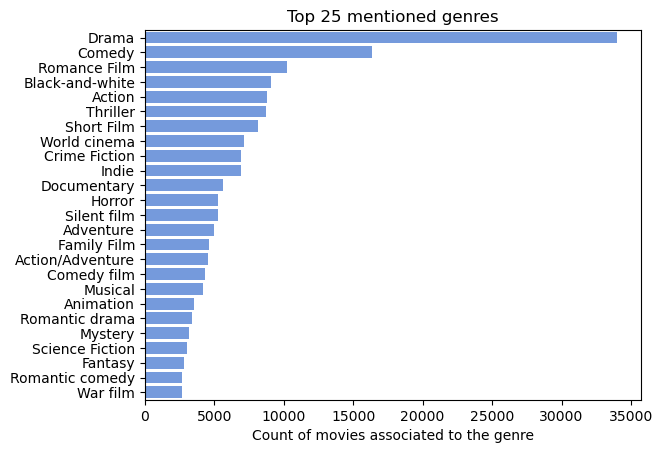

In [35]:
sns.barplot(data = unique_genres[['movie_count']].head(25).reset_index(),
            x = 'movie_count', y = 'movie_genre', orientation = 'horizontal', color = '#6495ED')
plt.title("Top 25 mentioned genres")
plt.ylabel("")
plt.xlabel("Count of movies associated to the genre")

With this graph we can see that most of the movies are classified with genres that are not obviously speculative fiction.

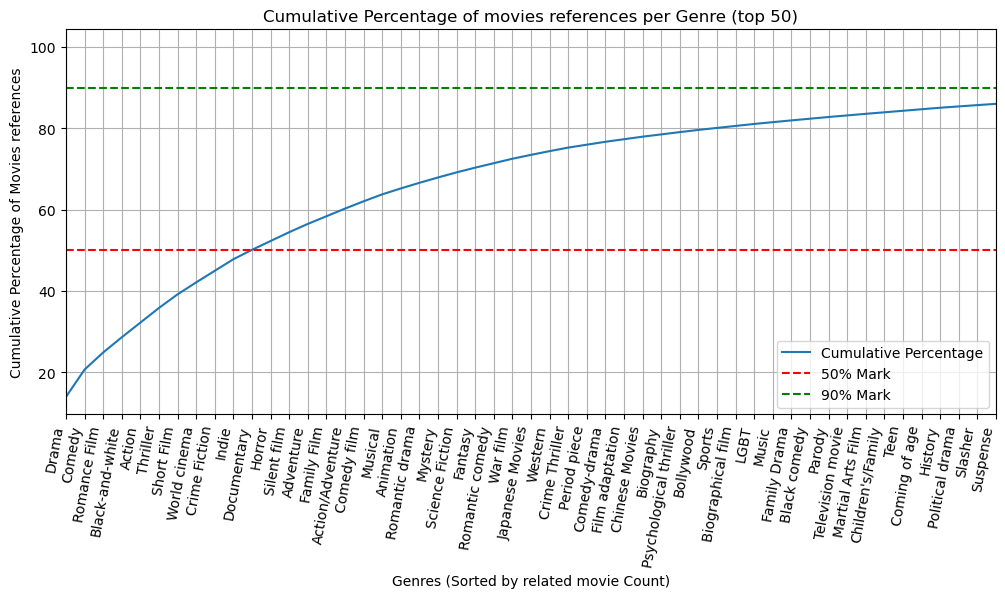

In [8]:
# Plot a cumulative percentage of movies by genre
plt.figure(figsize=(12, 5))
plt.plot((unique_genres['movie_count'].cumsum() / unique_genres['movie_count'].sum()) * 100,
         label='Cumulative Percentage')
plt.xticks(rotation=80, ha='right')
plt.xlim([0,50])

# Highlight the 50% and 90% mark
plt.axhline(y=50, color='r', linestyle='--', label='50% Mark')
plt.axhline(y=90, color='g', linestyle='--', label='90% Mark')

# Set labels and title
plt.xlabel('Genres (Sorted by related movie Count)')
plt.ylabel('Cumulative Percentage of Movies references')
plt.title('Cumulative Percentage of movies references per Genre (top 50)')
plt.legend()
plt.grid(True)
plt.show()

With this we can observe that if we take only the top 100 genres, almost 90% of the movie-genre relations are covered. 

## Part 2 : Fiction vs Non fiction : from the provided dataset to our sicentific questions

#### 2.1) Processing and statistics on two major genres related to fictional worlds : 'Science Fiction' and 'Fantasy'

For a first approach, we considered only two genres that are clearly fictional, Science Fiction and Fantasy.

In [9]:
df_fictional = df_genres[df_genres['movie_genre'].isin(['Science Fiction', 'Fantasy'])].copy()
print(f"The total number of movies referred to as fictional is {df_fictional['Wikipedia_movie_ID'].unique().size}, corresponding to {df_fictional['Wikipedia_movie_ID'].unique().size/df_movies['Wikipedia_movie_ID'].unique().size:.2%} of whole movies.")

The total number of movies referred to as fictional is 5366, corresponding to 6.56% of whole movies.


In [10]:
# populate the fictional genre dataset to add information on the movie as the release date
df_movies_fictional = pd.merge(df_fictional, df_movies[['Wikipedia_movie_ID', 'movie_name', 'movie_release_date']], on='Wikipedia_movie_ID', how='inner').copy()
df_movies_fictional['release_year'] =  pd.to_datetime(df_movies_fictional['movie_release_date'], format='mixed', errors='coerce').dt.year
df_movies_fictional_id = df_movies_fictional[~df_movies_fictional.duplicated('Wikipedia_movie_ID')].copy()
df_movies_fictional_id.head()

,Wikipedia_movie_ID,Freebase_genre_ID,movie_genre,movie_name,movie_release_date,release_year
0,975900,/m/06n90,Science Fiction,Ghosts of Mars,2001-08-24,2001.0
1,18998739,/m/01hmnh,Fantasy,The Sorcerer's Apprentice,2002,2002.0
2,11250635,/m/06n90,Science Fiction,The Mechanical Monsters,NaN,NaN
4,77856,/m/01hmnh,Fantasy,Mary Poppins,1964-08-27,1964.0
5,612710,/m/06n90,Science Fiction,New Rose Hotel,1999-10-01,1999.0


In [11]:
# creaete a new column with only the release year
df_movies['release_year'] = pd.to_datetime(df_movies['movie_release_date'], format='mixed', errors='coerce').dt.year

Calculate the fraction of fictional movies over the years

In [12]:
# Group by year with NaN
grouped_all_movies = df_movies.groupby('release_year')['release_year'].count()
# Group by year with NaN for fictional movies
grouped_genre_movies = df_movies_fictional_id.groupby('release_year')['release_year'].count()

Text(0, 0.5, 'percentage')

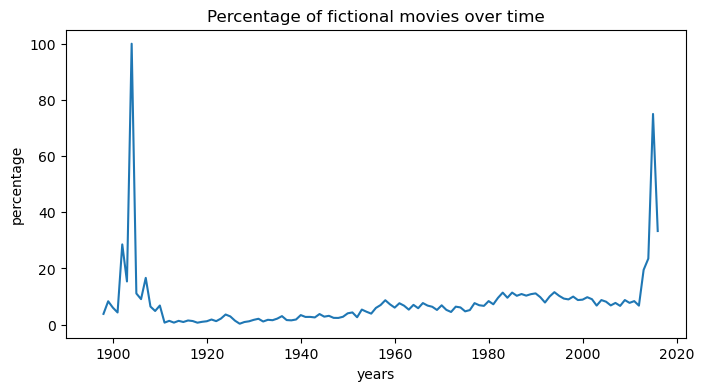

In [13]:
# Replace NaN values by 0 
grouped_all_movies = grouped_all_movies.fillna(0)

# Calculate the fraction of fictional movies over the years, with NaN values as 0
fraction_by_year = (grouped_genre_movies / grouped_all_movies)*100

# figure
plt.figure(figsize=(8,4))
plt.plot(fraction_by_year.index,fraction_by_year.values)
plt.title("Percentage of fictional movies over time")
plt.xlabel("years")
plt.ylabel("percentage")

The percentage of fictional movies (SF and Fantasy) slowly increased over the years from 1910th to 2015. The extreme values before this date are due to the very little number of movies released (for example in 1902 only 3 movies were released and were all fiction).In 2015 we noticed a high value that need additional analysis.

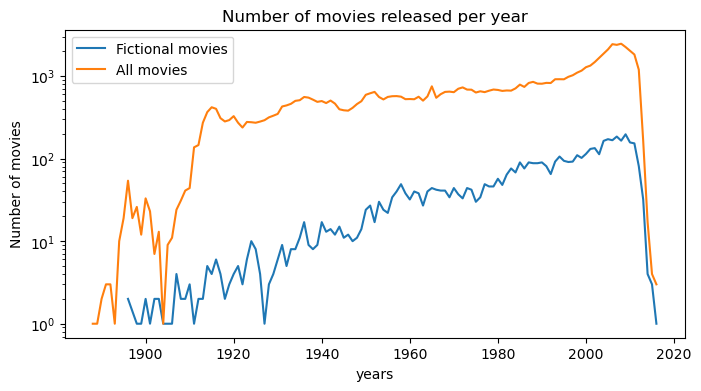

In [42]:
# Figure of number of movies released per year
plt.figure(figsize=(8,4))
plt.semilogy(grouped_genre_movies.index, grouped_genre_movies.values, label = "Fictional movies")
plt.semilogy(grouped_all_movies.index, grouped_all_movies.values, label = "All movies")
plt.xlabel('years')
plt.ylabel('Number of movies')
plt.title('Number of movies released per year')
plt.legend()

We observe that the number of fictional movies increases through time but the total number of movies relased per year increases very slowly.
It's visible that before 1940, there is a inconsistent number of fictional movies. This needs to be taken into account during further analysis.

#### 2.2) Naive-Bayes ML for improved speculative fictional summaries classification ! 

A first approach to extract fictional movies is to only consider movies genres that are clearly fictional like "Science-fiction" or "Supernatural". Nevertheless, this method as it is human made, this method is biased. Then, genre classification may make us miss some speculative movies that are not classified as “obvious” speculative fiction genres. For example, it is not possible to extract the fiction degree of a movie only classified as an “action movie”. In this way, we want to use Naive-Bayes ML to improve speculative fictional summaries classification.

In this part, we discuss the Naive-Bayes ML approach for classification, the relevance of its results and we try to improve it by testing hyperparameters and feature processing as TF-IDF and stemming.

We will for now, take all summaries of the genre "Science Fiction" and "Fantasy" vs the "documentary", "'Documentary', 'Biography', 'Culture & Society', 'Biographical film', 'Biopic [feature]' and 'History' as training of the classifier. This is for pipeline testing purpose and the biais and confounders of such a choice of training dataset should be discussed.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import nltk
from nltk.stem.snowball import SnowballStemmer

In [17]:
# to work with nltk snowballstemmer, need to download the following data (only once)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dohyg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# Get 2 subset of movies ID based on genre clearly fictional and non fictional
fictional_wiki_movie_id = df_fictional['Wikipedia_movie_ID'].unique().copy() #defined in Part 1 ('Science Fiction' and 'Fantasy')
non_fictional_wiki_movie_id = df_genres[df_genres['movie_genre'].isin(['Documentary', 'Biography', 'Culture & Society', 'Biographical film', 'Biopic [feature]', 'History'])]['Wikipedia_movie_ID'].unique().copy()

print(f"The total number of movies IDs in each subset for fictional is {fictional_wiki_movie_id.size} and for non-fictional is {non_fictional_wiki_movie_id.size}.")

The total number of movies IDs in each subset for fictional is 5366 and for non-fictional is 7778.


In [19]:
# Now we find the summaries associated to each movies. (Note: not all movies have a summary !)
fictional_summaries = df_summaries[df_summaries['movie_ID'].isin(fictional_wiki_movie_id)]['movie_summary']
non_fictional_summaries = df_summaries[df_summaries['movie_ID'].isin(non_fictional_wiki_movie_id)]['movie_summary']

print(f"The total number of summaries in each subset for fictional is {fictional_summaries.size} and for non-fictional is {non_fictional_summaries.size}.")
print(f'The percents of fictional and non-fictional summaries are: {fictional_summaries.size/ (fictional_summaries.size + non_fictional_summaries.size):.1%} vs {non_fictional_summaries.size/ (fictional_summaries.size + non_fictional_summaries.size):.1%}')

The total number of summaries in each subset for fictional is 3941 and for non-fictional is 2382.
The percents of fictional and non-fictional summaries are: 62.3% vs 37.7%


Since the number of summaries in both subsets is not equal and to avoid that the model is biased towards the bigger class, the bigger subset, here fictional summaries, is undersampled randomly to match sizes. Then each class is labeled (binary): 1 for fictional movies and 0 for non fictional one.

In [20]:
# undersample the fictional summaries
fictional_summaries_undersampled = fictional_summaries.sample(len(non_fictional_summaries))
# Concatenate the summaries and create associated labeling array.
selected_summaries = pd.concat((fictional_summaries_undersampled, non_fictional_summaries)).copy()
labels = np.hstack((np.ones(fictional_summaries_undersampled.shape), np.zeros(non_fictional_summaries.shape)))

print(f'The final shape of the dataset is : {selected_summaries.shape} and labels also corresponds : {labels.shape}')

The final shape of the dataset is : (4764,) and labels also corresponds : (4764,)


In [21]:
# Split the data into training and testing with proportion 0.7 and 0.3.
x_train, x_test, y_train, y_test = train_test_split(selected_summaries, labels, test_size=0.3, random_state=42) 

print("Training set size:", len(x_train))
print("Test set size:", len(x_test))

Training set size: 3334
Test set size: 1430


Check if there are some movies in the fictional dataframe that are also in the dataframes containing all genres

In [22]:
conflict = df_movies_fictional_id[df_movies_fictional_id["Wikipedia_movie_ID"].isin(non_fictional_wiki_movie_id)]
print(f'The number of movies that appear in both fictionnal and non fictionnal dataframe is : {conflict.shape[0]}')


The number of movies that appear in both fictionnal and non fictionnal dataframe is : 44


Now that we have a first training set, we can create the pipeline for the machine learning. We chose the multinomial naives bayes to be a simple but efficient method that works well with text data. As a probabilistic classifier, the naive model assumes that the features (here word count) are independant of the class. This assumption is often violated in case of text classification since words in a document are often related, and their occurrence may be correlated. This has to be kept in mind because more the assumption is wrong, weaker would the performance of this models be expected. (ref. <url> https://developer.ibm.com/tutorials/awb-classifying-data-multinomial-naive-bayes-algorithm/ <url/>)

Mutlinomial NB takes as input a word vector. Here the most basic approach would be a count vectorizer. But since the summaries vary in length, a normalization of the count as TF-IDF could be relevant to avoid a bais towards bigger summaries. We will test both approaches.

In [23]:
# Create a sklearn pipeline with 2 successive feature processing and the ML model
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])
# fit the pipeline on the training set
text_clf = text_clf.fit(x_train, y_train)

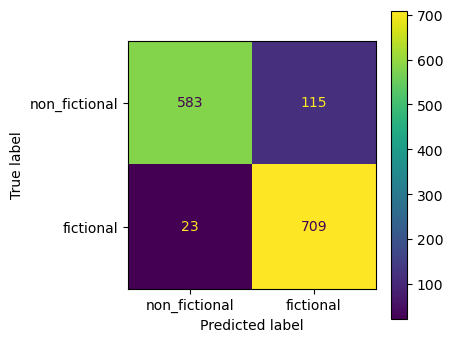

In [24]:
# Test the model of the test set and plot result in confusion matrix
predicted_test = text_clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, predicted_test)

# Plot the confusion matrix
fig, ax = plt.subplots(1,1,figsize=(4,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['non_fictional', 'fictional'])
disp.plot(ax=ax)
plt.show()

In [25]:
# Get more important metrics with classification report
class_report = classification_report(y_test, predicted_test, target_names=['non_fictional', 'fictional'])

print("Classification Report:")
print(class_report)

Classification Report:
               precision    recall  f1-score   support

non_fictional       0.96      0.84      0.89       698
    fictional       0.86      0.97      0.91       732

     accuracy                           0.90      1430
    macro avg       0.91      0.90      0.90      1430
 weighted avg       0.91      0.90      0.90      1430



With sklearn GridSearchSCV based on cross validation, we can test multiple relevant hyperparameters of our pipeline to see if some improvement can be observed. Here we can test the removal of the stop words, the complexity of the classifier (clf_alpha), the prior fitting of the classifier (clf_fit_prior) or the use of inverse-document-frequency (idf) reweighting. 

In [26]:
# The different parameters to test
param_grid = {
    'vect__stop_words': ['english', None],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
    'clf__fit_prior': [False, True]
} 

grid_search = GridSearchCV(text_clf, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and accuracy
for param, value in best_params.items():
    print(f"{param}: {value}")
print("Best score:", grid_search.best_score_)

clf__alpha: 0.01
clf__fit_prior: True
tfidf__use_idf: False
vect__stop_words: None
Best score: 0.8934329574808609


In [27]:
# And measures the metrics on the prediction in test set with this optimized model 
predicted_test = best_model.predict(x_test)

# Measures metrics with classification report
class_report = classification_report(y_test, predicted_test, target_names=['non_fictional', 'fictional'])

print("Classification Report:")
print(class_report)

Classification Report:
               precision    recall  f1-score   support

non_fictional       0.92      0.89      0.90       698
    fictional       0.90      0.93      0.91       732

     accuracy                           0.91      1430
    macro avg       0.91      0.91      0.91      1430
 weighted avg       0.91      0.91      0.91      1430



We observe a small improvement. As another test, we wanted to see if our model is able to classify recent movies summary. From the genres it was trained on and other ones. 

In [28]:
with open("PeterPan.txt", "r") as text_file:
    plot2test = text_file.read()

best_model.predict([plot2test])

FileNotFoundError: [Errno 2] No such file or directory: 'PeterPan.txt'

In [ ]:
t = "The dangerous world of free diving, director Lauren McGann follows the early lives and careers of Italian free diver Alessia Zecchini, who's determined to break the world record, and Irish safety diver Stephen Keenan, who accompanies Zecchini partway down to help in case something goes wrong."
text_clf.predict([t])

The feature processing is important. Here the features are the words, therefore it is relevant to test also if trying to regroup words as for example in stems, can improve the model.

In [ ]:
# We can also try complexer word vectorization, here with nltk snowballstemmer algorithm
stemmer = SnowballStemmer("english")

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizer()

# create new pipeline and train it
text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect),
                             ('tfidf', TfidfTransformer()),
                             ('mnb', MultinomialNB())])

text_mnb_stemmed = text_mnb_stemmed.fit(x_train, y_train)

# predict the test set and measure metrics
predicted_mnb_stemmed = text_mnb_stemmed.predict(x_test)
class_report = classification_report(y_test, predicted_mnb_stemmed, target_names=['non_fictional', 'fictional'])

print("Classification Report:")
print(class_report)

# Part 3: Feature extraction from the fictional movies

In [ ]:
# import further necessary packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

# For nltk processing, only needed to download once
if False:
    import ntlk
    nltk.download('averaged_perceptron_tagger')
    nltk.download('punkt')

In [ ]:
# Data sample
sample_summaries = fictional_summaries.copy()

# General parameters to adapt
n_features = 1000
n_components = 10
n_top_words = 10

# Text preprocessing to remove Proper nouns (NPP)
def filter_names(text):
    """
    Filters out all Proper Nouns based on nltk token tags.

    Args:
        text (str): text to be filtered

    Returns:
        str: filtered text
    """
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    filtered_tokens = [token for token, pos in tagged_tokens if pos != 'NNP']
    return ' '.join(filtered_tokens)

# Preprocess the documents
preprocessed_sample_summaries = [filter_names(doc) for doc in sample_summaries]

# Vectorize the summaries
vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
dtm = vectorizer.fit_transform(preprocessed_sample_summaries)

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=11,
)

lda.fit(dtm)

# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda, n_words=10):
    """
    ...

    Args:
        vectorizer (_type_, optional): _description_. Defaults to vectorizer.
        lda_model (_type_, optional): _description_. Defaults to lda.
        n_words (int, optional): _description_. Defaults to 10.

    Returns:
        _type_: _description_
    """
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

# Show the topics with their n_top words in a DataFrame form
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda, n_words=n_top_words)
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

In [ ]:
def plot_top_words(model, feature_names, n_top_words, n_topics, title):
    """_summary_

    Args:
        model (_type_): _description_
        feature_names (_type_): _description_
        n_top_words (_type_): _description_
        n_topics (_type_): _description_
        title (_type_): _description_
    """
    row_n = np.ceil(n_topics/5).astype(int)
    col_n = min([n_topics, 5])
    fig, axes = plt.subplots(row_n, col_n, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, n_topics=n_components, title="Topics in LDA model")

In [ ]:
def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)

mdiff, annotation = lda.diff(lda, distance='jaccard', num_words=50)
plot_difference_matplotlib(mdiff, title="Topic difference (one model) [jaccard distance]", annotation=annotation)